# Color image segmentation using k-means, GMM and mean-shift
Mount the shared google drive folder to read the images

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import copy

from time import time

from google.colab import drive
drive.mount('/content/drive')
image_path = '/content/drive/Shareddrives/ImageVideoAnalysis/Datasets/Sample_images/'

def highlight_contours(img):
    dx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=3)
    dy = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=3)
    dx1, dx2, dx3 = cv2.split(dx)
    dy1, dy2, dy3 = cv2.split(dy)
    d = np.abs(dx1) + np.abs(dx2) + np.abs(dx3) + np.abs(dy1) + np.abs(dy2) + np.abs(dy3)
    mask = d==0
    return cv2.merge( (mask.astype('uint8'), mask.astype('uint8'), mask.astype('uint8')) )


Mounted at /content/drive


### k-means in the color space

Image size  (427, 570, 3)  Depth:  uint8


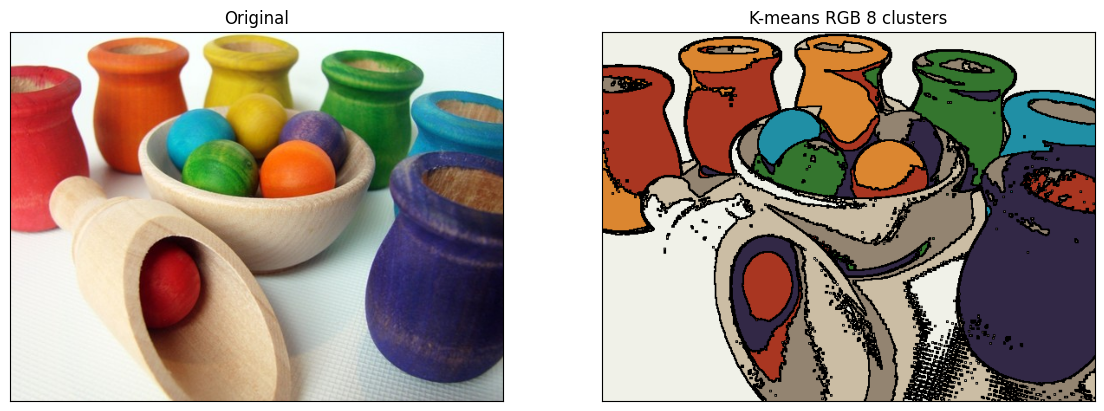

In [ ]:
from sklearn.cluster import KMeans

#filename = 'african-elephant.jpg'
filename = 'cups.jpg'

img = cv2.imread(image_path + filename, -1)
print('Image size ', img.shape, ' Depth: ', img.dtype)

HSV=False # possiamo operare in HSV oppure in RGB, false si va in RGB
if HSV:
  img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

b,g,r = cv2.split(img)


num_clusters = 8
# Warning: X is 3xNum_pixels. To fit the kmeans model X.T should be used
X = np.array([b.reshape(-1), g.reshape(-1), r.reshape(-1)]) # trasformano i pixel dell'immagine in una matrice di dati, concatena in colonna le componenti R,G,B, X è una matrice di dati
km=KMeans(n_clusters=num_clusters,init='k-means++', max_iter=300, n_init=10, random_state=0) #n_init numero di inizializzazione
km.fit(X.T) # fitting di k-means sui dati
# extract the cluster ID of each pixel
Y = km.fit_predict(X.T) # viene applicato il fitting ai dati, si cerca per ogni pixel il centro del cluster a cui appartiene

# processo inverso, dalla matrice dei dati devo ricostruire i piani e quindi l'immagine

b_remap = copy.deepcopy(b.reshape(-1))
g_remap = copy.deepcopy(g.reshape(-1))
r_remap = copy.deepcopy(r.reshape(-1))
for k in range(num_clusters):
    b_remap[ Y==k ] = km.cluster_centers_[k,0]
    g_remap[ Y==k ] = km.cluster_centers_[k,1]
    r_remap[ Y==k ] = km.cluster_centers_[k,2]

img_remap = cv2.merge( (b_remap.reshape(r.shape),
                        g_remap.reshape(r.shape),
                        r_remap.reshape(r.shape)) ) # con reshape abbiamo questa ristrutturazione, con merge abbiamo come riottenere l'immagine risegmentata
if HSV:
  img_remap = cv2.cvtColor(img_remap, cv2.COLOR_HSV2RGB)
  img = cv2.cvtColor(img, cv2.COLOR_HSV2RGB)
else:
  img_remap = cv2.cvtColor(img_remap, cv2.COLOR_BGR2RGB)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

img_c = highlight_contours(img_remap)
#print('Image size ', img_c.shape, ' Depth: ', img_c.dtype)
img_remap = img_remap * img_c

plt.figure(figsize=(14,8))
plt.subplot(1,2,1), plt.imshow(img)
plt.title('Original'), plt.xticks([]), plt.yticks([])
plt.subplot(1,2,2), plt.imshow(img_remap)
if HSV:
  plt.title('K-means HSV %d clusters'%(num_clusters)), plt.xticks([]), plt.yticks([])
else:
  plt.title('K-means RGB %d clusters'%(num_clusters)), plt.xticks([]), plt.yticks([])
plt.show()




## k-means in the combined spatial and color space

Image size  (427, 570, 3)  Depth:  uint8
Image size  (427, 570, 3)  Depth:  uint8


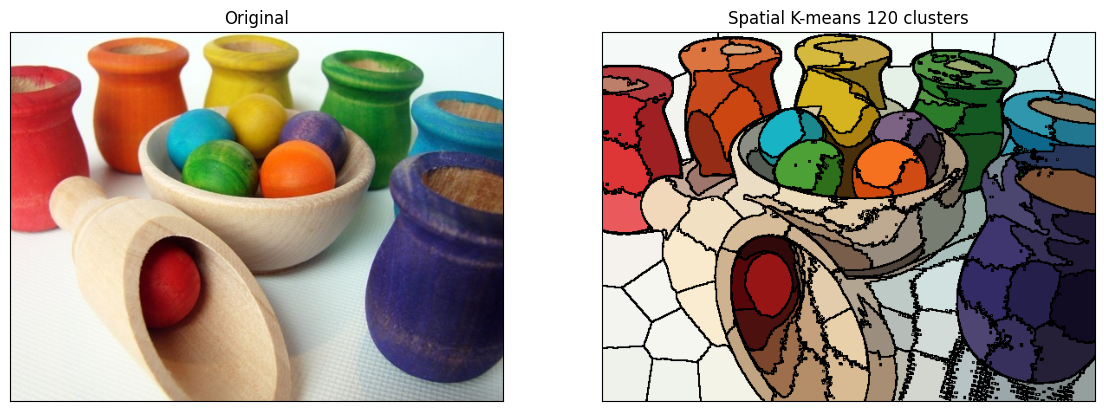

In [ ]:
# viene spiegato come aggiungere le coordinate spaziali, oltre a quelle colori, quindi R,G,B,x,y. Le regioni individuate nel clustering sono patches coese, evita di avere una corrispondenza di un cluster a più regioni

HSV = False
spatial = True

#filename = 'african-elephant.jpg'
filename = 'cups.jpg'

img = cv2.imread(image_path + filename, -1)
print('Image size ', img.shape, ' Depth: ', img.dtype)

if HSV:
    img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

b,g,r = cv2.split(img)
num_clusters = 120 # deve essere più alto

# come vengono inglobate le coordinate x, y nel vettore features? con la funzione meshgrid, poco più sotto

if spatial : #Embed spatial coordinates in the feature vector
    # Now compute the x and y coordinates of each pixel
    x,y = np.meshgrid(range(img.shape[1]), range(img.shape[0]),
                      sparse=False, indexing='xy') # meshgrid estrae tutte le coordinate x, y dei pixel
    # Warning: X is 3xNum_pixels. To fit the clustering model use X.T
    X = np.array([b.reshape(-1), g.reshape(-1), r.reshape(-1),
                  x.reshape(-1), y.reshape(-1)]) # X è una matrice di dati che è 5 quanti sono i pixel dell'immagine
else:
    X = np.array([b.reshape(-1), g.reshape(-1), r.reshape(-1)])

km=KMeans(n_clusters=num_clusters,init='k-means++', max_iter=300, n_init=1, random_state=0)
km.fit(X.T) # su questa matrice faccio il fit
# extract the cluster ID of each pixel
Y = km.fit_predict(X.T)

b_remap = copy.deepcopy(b.reshape(-1))
g_remap = copy.deepcopy(g.reshape(-1))
r_remap = copy.deepcopy(r.reshape(-1))
for k in range(num_clusters):
    b_remap[ Y==k ] = km.cluster_centers_[k,0]
    g_remap[ Y==k ] = km.cluster_centers_[k,1]
    r_remap[ Y==k ] = km.cluster_centers_[k,2]

if HSV:
    img_remap = cv2.merge( (b_remap.reshape(r.shape),
                        g_remap.reshape(r.shape),
                        r_remap.reshape(r.shape)) )
    img_remap = cv2.cvtColor(img_remap, cv2.COLOR_HSV2RGB)
    img = cv2.cvtColor(img, cv2.COLOR_HSV2RGB)
else:
    img_remap = cv2.merge( (r_remap.reshape(r.shape),
                        g_remap.reshape(r.shape),
                        b_remap.reshape(r.shape)) )
    img = cv2.merge( (r,g,b) )

img_c = highlight_contours(img_remap)
print('Image size ', img_c.shape, ' Depth: ', img_c.dtype)
img_remap = img_remap * img_c

plt.figure(figsize=(14,8))
plt.subplot(1,2,1), plt.imshow(img)
plt.title('Original'), plt.xticks([]), plt.yticks([])
plt.subplot(1,2,2), plt.imshow(img_remap)
plt.title('Spatial K-means %d clusters'%(num_clusters)), plt.xticks([]), plt.yticks([])
plt.show()



## GMM in the combined spatial and color space

Image size  (427, 570, 3)  Depth:  uint8


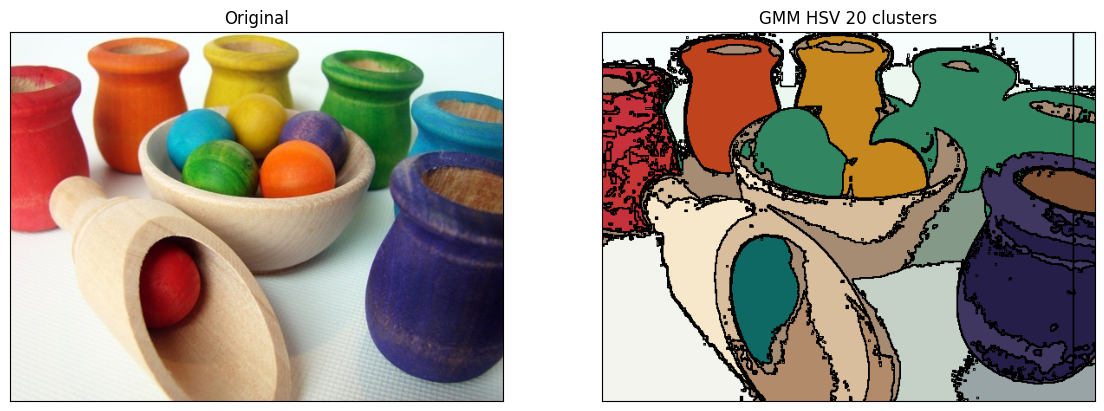

In [ ]:
from sklearn.mixture import GaussianMixture

#filename = 'african-elephant.jpg'
filename = 'cups.jpg'

img = cv2.imread(image_path+filename, -1)
img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
b,g,r = cv2.split(img)

num_clusters = 20
# Warning: X is 3xNum_pixels. To fit the kmeans model X.T should be used
spatial = True
if spatial : #Embed spatial coordinates in the feature vector
    # Now compute the x and y coordinates of each pixel
    x,y = np.meshgrid(range(img.shape[1]), range(img.shape[0]), sparse=False, indexing='xy')
    # Warning: X is 3xNum_pixels. To fit the clustering model X.T should be used
    X = np.array([b.reshape(-1), g.reshape(-1), r.reshape(-1), x.reshape(-1), y.reshape(-1)])
else:
    X = np.array([b.reshape(-1), g.reshape(-1), r.reshape(-1)])
#X = np.array([b.reshape(-1), g.reshape(-1), r.reshape(-1)])
gmm=GaussianMixture(n_components=num_clusters,
                   covariance_type='diag',
                   init_params='kmeans',
                   max_iter=300, n_init=4, random_state=10) # covariance_type corrisponde nel caso del metodo del modello GMM è possibile specificare il vincolo da imporre sulla matrice di covarianza, se 'full' non ho vincoli, è simmetrica con componenti extradiagonali diversi da zero, tied extradiagonali diversi dazero, ma tutte le gaussiane hanno la stessa matrice di covarianza
# diag ogni gaussiana ha la sua matrice di covarianza, spherical è quella in cui ogni gaussiana ha la sua matrice di covarianza ma questa è data da uno scalare ...(?)
# init_params prevede di usare k-means per cercare la posizione iniziale dei cluster
gmm.fit(X.T)
# extract the cluster ID of each pixel
Y = gmm.predict(X.T)

b_remap = copy.deepcopy(b.reshape(-1))
g_remap = copy.deepcopy(g.reshape(-1))
r_remap = copy.deepcopy(r.reshape(-1))
for k in range(num_clusters):
    b_remap[ Y==k ] = gmm.means_[k,0]
    g_remap[ Y==k ] = gmm.means_[k,1]
    r_remap[ Y==k ] = gmm.means_[k,2]

img_remap = cv2.merge( (b_remap.reshape(r.shape),
                        g_remap.reshape(r.shape),
                        r_remap.reshape(r.shape)) )
img_remap = cv2.cvtColor(img_remap, cv2.COLOR_HSV2RGB)
img = cv2.cvtColor(img, cv2.COLOR_HSV2RGB)

img_c = highlight_contours(img_remap)
print('Image size ', img_c.shape, ' Depth: ', img_c.dtype)
img_remap = img_remap * img_c

plt.figure(figsize=(14,8))
plt.subplot(1,2,1), plt.imshow(img)
plt.title('Original'), plt.xticks([]), plt.yticks([])
plt.subplot(1,2,2), plt.imshow(img_remap)
plt.title('GMM HSV %d clusters'%(num_clusters)), plt.xticks([]), plt.yticks([])
plt.show()


## Mean-shift in the combined spatial and color space

Image size  (427, 570, 3)  Depth:  uint8


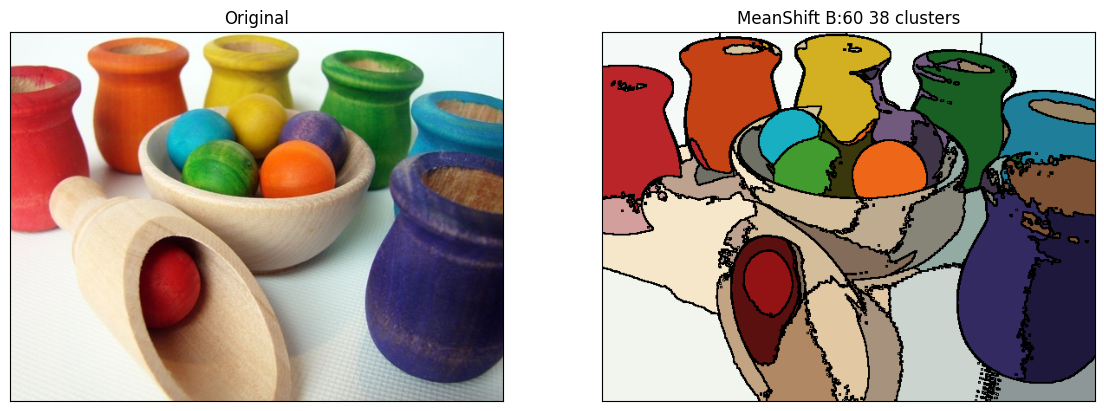

In [ ]:
from sklearn.cluster import MeanShift, estimate_bandwidth

#filename = 'african-elephant.jpg'
filename = 'cups.jpg'

img = cv2.imread(image_path + filename, -1)

b,g,r = cv2.split(img)
spatial = True
if spatial : #Embed spatial coordinates in the feature vector
    # Now compute the x and y coordinates of each pixel
    x,y = np.meshgrid(range(img.shape[1]), range(img.shape[0]), sparse=False, indexing='xy')
    # Warning: X is 3xNum_pixels. To fit the clustering model X.T should be used
    X = np.array([b.reshape(-1), g.reshape(-1), r.reshape(-1), x.reshape(-1), y.reshape(-1)])
else:
    X = np.array([b.reshape(-1), g.reshape(-1), r.reshape(-1)])

bandwidth = 60 #estimate_bandwidth(X.T, quantile=0.2, n_samples=500)
ms=MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms.fit(X.T)
# extract the cluster ID of each pixel
Y = ms.fit_predict(X.T)
labels = ms.labels_
labels_unique = np.unique(labels)
num_clusters = len(labels_unique)

b_remap = copy.deepcopy(b.reshape(-1))
g_remap = copy.deepcopy(g.reshape(-1))
r_remap = copy.deepcopy(r.reshape(-1))
for k in range(num_clusters):
    b_remap[ Y==k ] = ms.cluster_centers_[k,0]
    g_remap[ Y==k ] = ms.cluster_centers_[k,1]
    r_remap[ Y==k ] = ms.cluster_centers_[k,2]

img_remap = cv2.merge( (r_remap.reshape(r.shape),
                        g_remap.reshape(r.shape),
                        b_remap.reshape(r.shape)) )
img = cv2.merge( (r,g,b) )


img_c = highlight_contours(img_remap)
print('Image size ', img_c.shape, ' Depth: ', img_c.dtype)
img_remap = img_remap * img_c

plt.figure(figsize=(14,8))
plt.subplot(1,2,1), plt.imshow(img)
plt.title('Original'), plt.xticks([]), plt.yticks([])
plt.subplot(1,2,2), plt.imshow(img_remap)
plt.title('MeanShift B:%d %d clusters'%(np.int16(bandwidth),num_clusters)), plt.xticks([]), plt.yticks([])
plt.show()
